In [3]:
import sys
sys.path.append("..")
import importlib
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

import system.experimental_september as system
importlib.reload(system)
import utils.solver as solver
importlib.reload(solver)
import pulse.tukey as pulse_gen
importlib.reload(pulse_gen)
import pulse.tukey_derivative as tukey_derivative
importlib.reload(tukey_derivative)
import utils.expectation_values as expect
importlib.reload(expect)
import optimization.grape as grape
importlib.reload(grape)

pass

# Optimize pulse via standard parameter gradient descent

## First, find descent starting point

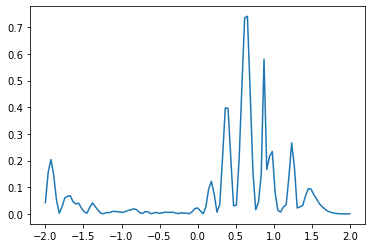

In [45]:
from qutip.parallel import parallel_map as parallel_map
from qutip.parallel import parfor as parfor
from tqdm import tqdm as tqdm
all_results = []
_amp = 5.5*2*np.pi
_off = 0
_dur = 20
_ramp_coef = 1

def vary_offset(off):
    tlist = np.linspace(0, _dur, int(_dur*5))
    pulse_gen.setup(amplitude=_amp, drive_frequency= system.first_energy_spacing/3 - off, ramp_coef=_ramp_coef, tlist=tlist)
    solution = solver.time_evolve(H_d=system.H0, H_c=system.H1, pertubation_func=pulse_gen.pulse_func, tlist=tlist, starting_state=system.basis_states[0], pbar=False)
    expectation_values = expect.get_all_expectation_values(solution.states, system.basis_states)
    return {
        "fidelity": expectation_values[1][-1],
        "offset": off,
        "frequency":  system.first_energy_spacing/3 - off,
        "duration": _dur,
        "amplitude": _amp
    }

offs_to_test = np.linspace(-2, 2, 111)
offset_varying_results = parfor(vary_offset, offs_to_test)

_fids_off_sweep = []
_offs_off_sweep = []
for result in offset_varying_results:
    _fids_off_sweep.append(result["fidelity"])
    _offs_off_sweep.append(result["offset"])

plt.plot(_offs_off_sweep, _fids_off_sweep)
plt.show()
# best_offset = offset_varying_results[np.argmax(_fids_off_sweep)]["offset"]
# offs_to_test = np.linspace(best_offset-0.01, best_offset+0.01, 50)
# offset_varying_results = parfor(vary_offset, offs_to_test)

In [46]:
offset = offset_varying_results[np.argmax(_fids_off_sweep)]["offset"]
duration = offset_varying_results[np.argmax(_fids_off_sweep)]["duration"]
amplitude = offset_varying_results[np.argmax(_fids_off_sweep)]["amplitude"]
offset_varying_results[np.argmax(_fids_off_sweep)]

{'fidelity': 0.7415041699831474,
 'offset': 0.6545454545454543,
 'frequency': 7.662653544225332,
 'duration': 20,
 'amplitude': 34.55751918948772}

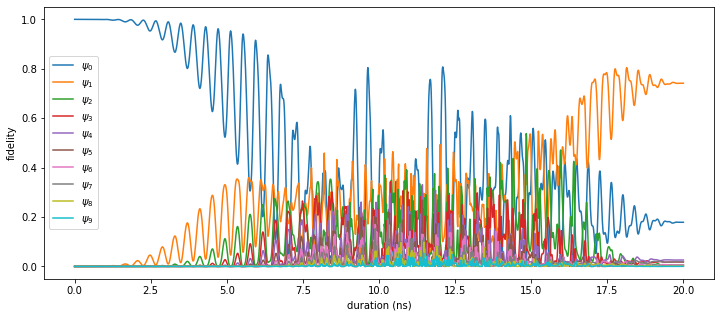

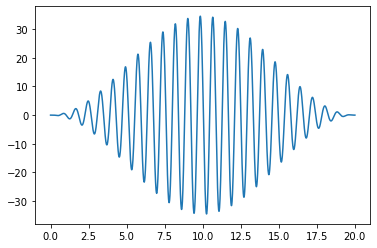

In [47]:
import utils.graph as g

tlist = np.linspace(0, duration, int(duration*100))
pulse_gen.setup(amplitude=amplitude, drive_frequency= system.first_energy_spacing/3 - offset, ramp_coef=_ramp_coef, tlist=tlist)
solution = solver.time_evolve(H_d=system.H0, H_c=system.H1, pertubation_func=pulse_gen.pulse_func, tlist=tlist, starting_state=system.basis_states[0], pbar=False)
g.graph_solution(solution, system)
pulse_gen.setup(amplitude=amplitude, drive_frequency= system.first_energy_spacing/3 - offset, ramp_coef=_ramp_coef, tlist=tlist)
plt.show()
plt.plot(tlist, pulse_gen.get_pulse(tlist))

## Next, start optimization with given params

In [21]:
def cost_standard(parameters, constants):
    # parameters = [offset, duration]
    offset = parameters[0]
    duration = parameters[1]
    # constants = [amplitude]
    amplitude = constants[0]
    tlist = np.linspace(0, duration, int(duration*5))
    pulse_gen.setup(amplitude=amplitude, drive_frequency= system.first_energy_spacing/3 - offset, ramp_coef=_ramp_coef, tlist=tlist)
    solution = solver.time_evolve(H_d=system.H0, H_c=system.H1, pertubation_func=pulse_gen.pulse_func, tlist=tlist, starting_state=system.basis_states[0], pbar=False)
    expectation_values = expect.get_all_expectation_values(solution.states, system.basis_states)
    fidelity = expectation_values[1][-1]
    return (1-fidelity)

offset = offset_varying_results[np.argmax(_fids_off_sweep)]["offset"]
duration = offset_varying_results[np.argmax(_fids_off_sweep)]["duration"]
amplitude = offset_varying_results[np.argmax(_fids_off_sweep)]["amplitude"]
optimization_result_standard = sp.optimize.minimize(cost_standard, [offset, duration], [amplitude], method="Nelder-Mead", options={"disp":True})

Optimization terminated successfully.
         Current function value: 0.074391
         Iterations: 45
         Function evaluations: 99


In [22]:
optimization_result_standard

 final_simplex: (array([[ 0.58227035, 27.21976789],
       [ 0.58227167, 27.21967737],
       [ 0.58227196, 27.21972441]]), array([0.07439123, 0.07439133, 0.07439172]))
           fun: 0.07439123487412536
       message: 'Optimization terminated successfully.'
          nfev: 99
           nit: 45
        status: 0
       success: True
             x: array([ 0.58227035, 27.21976789])

In [23]:
best_standard_fidelity = (1 - optimization_result_standard.fun)

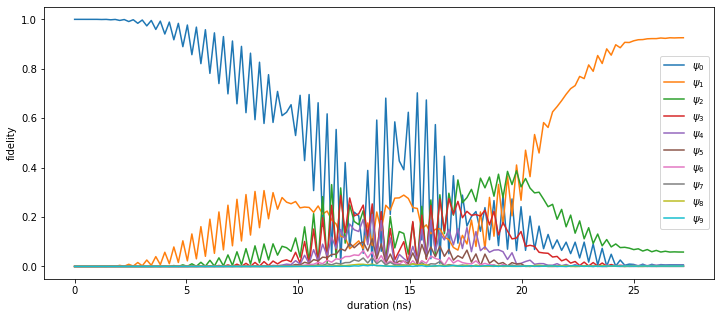

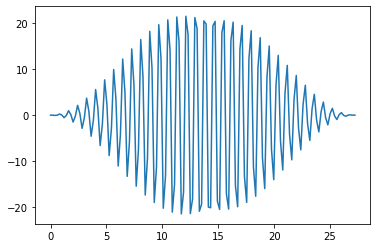

In [24]:
import utils.graph as g

tlist = np.linspace(0, optimization_result_standard.x[1], int(optimization_result_standard.x[1]*5))
pulse_gen.setup(amplitude=amplitude, drive_frequency= system.first_energy_spacing/3 - optimization_result_standard.x[0], ramp_coef=_ramp_coef, tlist=tlist)
solution = solver.time_evolve(H_d=system.H0, H_c=system.H1, pertubation_func=pulse_gen.pulse_func, tlist=tlist, starting_state=system.basis_states[0], pbar=False)
g.graph_solution(solution, system)
pulse_gen.setup(amplitude=amplitude, drive_frequency= system.first_energy_spacing/3 - optimization_result_standard.x[0], ramp_coef=_ramp_coef, tlist=tlist)
plt.show()
plt.plot(tlist, pulse_gen.get_pulse(tlist))

# Add DRAG correction
Optimize drag coefficient to try to increase fidelity

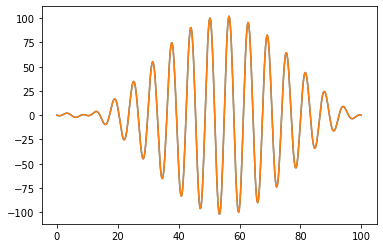

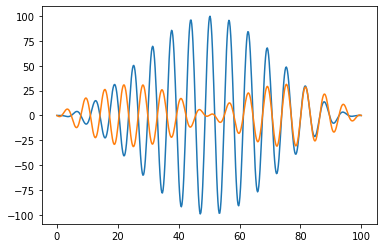

In [63]:
tlist = np.linspace(0, 100, int(100*5))
pulse_gen.setup(amplitude=100, drive_frequency= 1, ramp_coef=1, tlist=tlist)
tukey_derivative.setup(amplitude=100, drive_frequency= 1, ramp_coef=1, tlist=tlist)
_drag_coef = -5
temp = []
for t in tlist:
    temp.append(pulse_with_DRAG(t))
plt.plot(tlist, temp)
plt.plot(tlist, np.vectorize(pulse_with_DRAG)(tlist))
plt.show()
plt.plot(tlist, pulse_gen.get_pulse(tlist))
plt.plot(tlist, tukey_derivative.get_pulse(tlist) * -10)
# derivative works!

In [54]:
_drag_coef

-6.25e-05

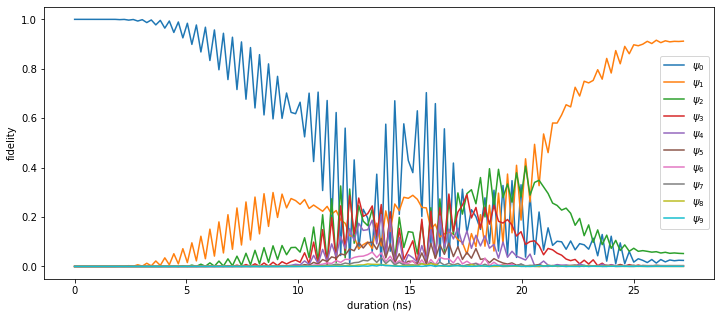

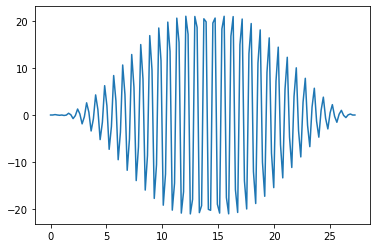

In [30]:
_drag_coef = -0.5

def pulse_with_DRAG(t, args=None):
    return pulse_gen.pulse_func(t) + _drag_coef * tukey_derivative.pulse_func(t)

tlist = np.linspace(0, optimization_result_standard.x[1], int(optimization_result_standard.x[1]*5))
pulse_gen.setup(amplitude=amplitude, drive_frequency= system.first_energy_spacing/3 - optimization_result_standard.x[0], ramp_coef=_ramp_coef, tlist=tlist)
tukey_derivative.setup(amplitude=amplitude, drive_frequency= system.first_energy_spacing/3 - optimization_result_standard.x[0], ramp_coef=_ramp_coef, tlist=tlist)
solution = solver.time_evolve(H_d=system.H0, H_c=system.H1, pertubation_func=pulse_with_DRAG, tlist=tlist, starting_state=system.basis_states[0], pbar=False)
g.graph_solution(solution, system)
plt.show()
plt.plot(tlist, np.vectorize(pulse_with_DRAG)(tlist))

In [48]:
_ramp_coef

1

## Sweep DRAG coefs

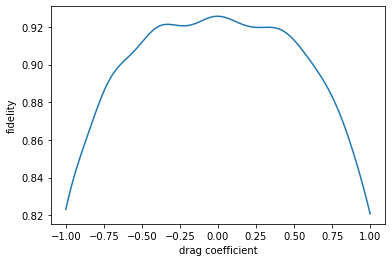

In [41]:
offset = constants[0]
duration = constants[1]
amplitude = constants[2]

def vary_drag(drag):
    def _pulse_with_DRAG(t, args=None):
        return pulse_gen.pulse_func(t) + drag * tukey_derivative.pulse_func(t)
    # tlist = np.linspace(0, duration, int(duration*5))
    # pulse_gen.setup(amplitude=_amp, drive_frequency= system.first_energy_spacing/3 - offset, ramp_coef=_ramp_coef, tlist=tlist)
    solution = solver.time_evolve(H_d=system.H0, H_c=system.H1, pertubation_func=_pulse_with_DRAG, tlist=tlist, starting_state=system.basis_states[0], pbar=False)
    expectation_values = expect.get_all_expectation_values(solution.states, system.basis_states)
    return {
        "fidelity": expectation_values[1][-1],
        "offset": offset,
        "frequency":  system.first_energy_spacing/3 - offset,
        "duration": duration,
        "amplitude": amplitude,
        "drag": drag
    }

drags_to_test = np.linspace(-1, 1, 111)
drag_varying_results = parfor(vary_drag, drags_to_test)

_fids_drag_sweep = []
_drags_drag_sweep = []
for result in drag_varying_results:
    _fids_drag_sweep.append(result["fidelity"])
    _drags_drag_sweep.append(result["drag"])

plt.plot(_drags_drag_sweep, _fids_drag_sweep)
plt.xlabel("drag coefficient")
plt.ylabel("fidelity")
plt.show()
best_drag_so_far = _drags_drag_sweep[np.argmax(_fids_drag_sweep)]

In [42]:
def cost_drag(parameters, constants):
    global _drag_coef
    _drag_coef = parameters[0]
    offset = constants[0]
    duration = constants[1]
    amplitude = constants[2]
    tlist = np.linspace(0, duration, int(duration*5))
    pulse_gen.setup(amplitude=amplitude, drive_frequency= system.first_energy_spacing/3 - offset, ramp_coef=_ramp_coef, tlist=tlist)
    tukey_derivative.setup(amplitude=amplitude, drive_frequency= system.first_energy_spacing/3 - offset, ramp_coef=_ramp_coef, tlist=tlist)
    solution = solver.time_evolve(H_d=system.H0, H_c=system.H1, pertubation_func=pulse_with_DRAG, tlist=tlist, starting_state=system.basis_states[0], pbar=False)
    expectation_values = expect.get_all_expectation_values(solution.states, system.basis_states)
    fidelity = expectation_values[1][-1]
    # debug stuff was here
    # g.graph_solution(solution, system)
    # plt.show()
    # print(offset ,duration, amplitude, _drag_coef)
    # input()
    print(fidelity)
    return (1-fidelity)

constants = optimization_result_standard.x
constants = np.append(constants, _amp)
optimization_result_drag = sp.optimize.minimize(cost_drag, [best_drag_so_far], constants, method="Nelder-Mead", options={"disp":True})

0.9256087651258746
0.9256054191856682
0.925606909221136
0.9256072910154618
0.9256082173569051
0.925605627927627
0.9256088175498471
Optimization terminated successfully.
         Current function value: 0.074391
         Iterations: 3
         Function evaluations: 7


In [43]:
_drag_coef = optimization_result_drag.x[0]
optimization_result_drag

 final_simplex: (array([[-6.25e-05],
       [ 0.00e+00]]), array([0.07439118, 0.07439123]))
           fun: 0.07439118245015286
       message: 'Optimization terminated successfully.'
          nfev: 7
           nit: 3
        status: 0
       success: True
             x: array([-6.25e-05])

In [44]:
best_drag_fidelity = 1 - optimization_result_drag.fun
print("best_drag_fidelity ", best_drag_fidelity)
print("best_standard_fidelity ", best_standard_fidelity)
print("improvement due to drag", best_drag_fidelity - best_standard_fidelity)

best_drag_fidelity  0.9256088175498471
best_standard_fidelity  0.9256087651258746
improvement due to drag 5.242397249638486e-08


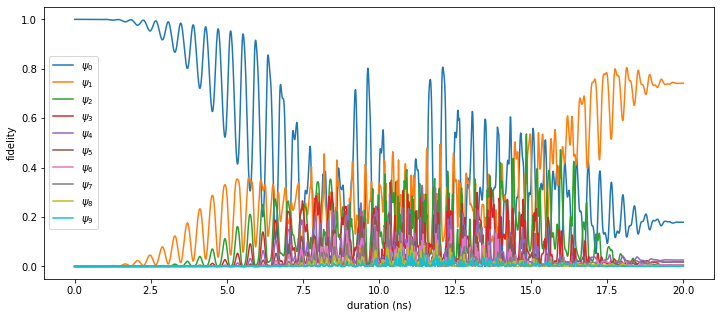

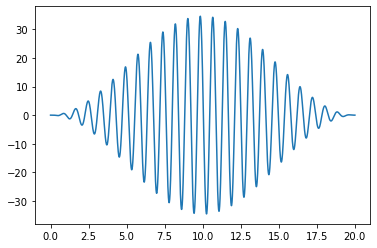

In [49]:
_drag_coef = -6.25e-05

def pulse_with_DRAG(t, args=None):
    return pulse_gen.pulse_func(t) + _drag_coef * tukey_derivative.pulse_func(t)

tlist = np.linspace(0, duration, int(duration*85))
pulse_gen.setup(amplitude=amplitude, drive_frequency= system.first_energy_spacing/3 - offset, ramp_coef=_ramp_coef, tlist=tlist)
solution = solver.time_evolve(H_d=system.H0, H_c=system.H1, pertubation_func=pulse_with_DRAG, tlist=tlist, starting_state=system.basis_states[0], pbar=False)
g.graph_solution(solution, system)
pulse_gen.setup(amplitude=amplitude, drive_frequency= system.first_energy_spacing/3 - offset, ramp_coef=_ramp_coef, tlist=tlist)
plt.show()
plt.plot(tlist, np.vectorize(pulse_with_DRAG)(tlist))

In [ ]:
np.vectorize(pulse_with_DRAG)(tlist)

# Start GRAPE with best DRAG curve

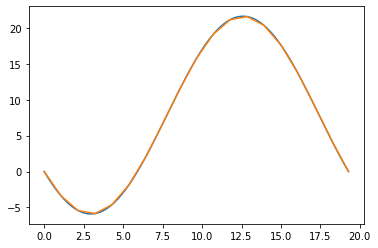

In [15]:
offset = constants[0]
duration = constants[1]
amplitude = constants[2]
tlist = np.linspace(0, duration, 10000)
# system.first_energy_spacing/3 - offset
pulse_gen.setup(amplitude, drive_frequency= 0 , ramp_coef=_ramp_coef, tlist=tlist)
tukey_derivative.setup(amplitude, drive_frequency= 0 , ramp_coef=_ramp_coef, tlist=tlist)
best_drag_pulse = pulse_gen.get_pulse(tlist) + _drag_coef * tukey_derivative.get_pulse(tlist)
plt.plot(tlist, best_drag_pulse)
bin_size = 1
smoothing_time = 5
binned_tlist = np.linspace(0, tlist[-1], int(tlist[-1]/bin_size))
binned_best_drag_pulse = pulse_gen.get_pulse(binned_tlist) + _drag_coef * tukey_derivative.get_pulse(binned_tlist)
plt.plot(binned_tlist, binned_best_drag_pulse)

In [16]:
grape.setup(system, binned_best_drag_pulse, offset, duration, bin_size, smoothing_time)

In [17]:
print(grape.config.time)
print(pulse)
print(grape.config.original_pulse)
print(grape.config.padding_t_slots)
print(len(grape.config.original_pulse))
plt.plot(grape.config.time, grape.config.original_pulse)
plt.plot(grape.config.smoothed_time, grape.config.original_pulse_smoothed)

[ 0.          1.04567357  2.09134714  3.13702071  4.18269428  5.22836785
  6.27404142  7.319715    8.36538857  9.41106214 10.45673571 11.50240928
 12.54808285 13.59375642 14.63942999 15.68510356 16.73077713 17.7764507
 18.82212427 19.86779784 20.91347142 21.95914499 23.00481856 24.05049213
 25.0961657  26.14183927 27.18751284 28.23318641 29.27885998]


NameError: name 'pulse' is not defined

In [ ]:
solution = grape.single_run()

best_drag_fidelity 0.9999994883387717
starting grape fidelity  0.9997869626371003
difference  -0.0002125257016714066
Fidelity = 0.999787, Offset = 0.240427


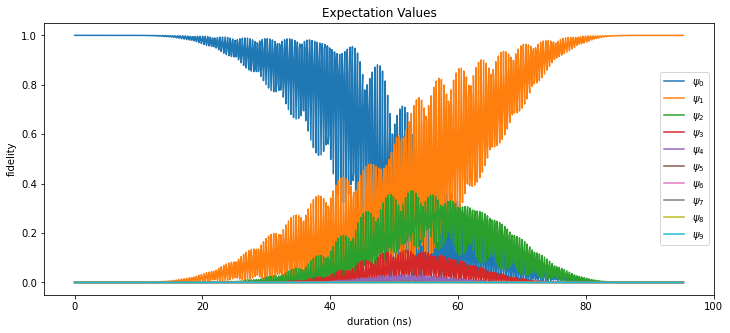

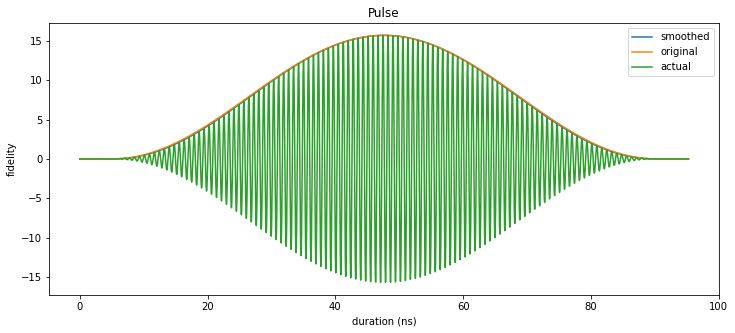

In [ ]:
print("best_drag_fidelity", best_drag_fidelity)
expectation_values = expect.get_all_expectation_values(grape.config.last_solution.states, system.basis_states)
print("starting grape fidelity ", expectation_values[1][-1])
print("difference ", expectation_values[1][-1] - best_drag_fidelity)

grape.graph_last_solution()

In [ ]:
# THIS TAKES TOO LONG AND WE LOSE PRECISION OF WAVE PULSE USING GRAPE

final_result = grape.optimize()

1 : 0.999787
2 : 0.999787
3 : 0.999786


capi_return is NULL
Call-back cb_f_in_zvode__user__routines failed.


KeyboardInterrupt: 

Fidelity = 0.995064, Offset = 0.364773


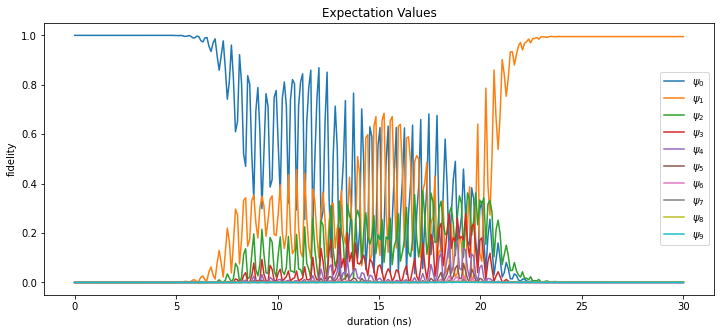

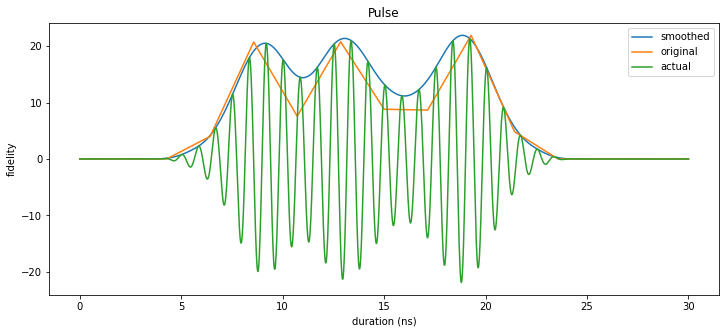

In [ ]:
grape.graph_last_solution()